# Проверка гипотез для увеличения выручки крупного интернет-магазина.

## Введение

### Описание проекта

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки.  
Необходимо: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

### Описание данных

Файл /datasets/hypothesis.csv.  
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

Файл /datasets/orders.csv.   
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv.   
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

## Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime as dt

In [3]:
hypothesis = pd.read_csv('C:/data yandex/hypothesis.csv')
orders = pd.read_csv('C:/data yandex/orders.csv')
visitors = pd.read_csv('C:/data yandex/visitors.csv')

In [4]:
pd.options.display.max_colwidth = 1
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Подготовка данных

### Заменим названия столбцов (приведём к нижнему регистру)

In [6]:
hypothesis.columns = hypothesis.columns.str.lower()

### Преобразуем данные о времени

In [7]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

### Переименуем название столбцов

In [8]:
orders.rename(columns={'transactionId':'orderId', 'visitorId':'userId'}, inplace=True)

### Проверим данные на дубликаты

In [9]:
print(hypothesis.duplicated().sum())
print()
print(orders.duplicated().sum())
print()
print(visitors.duplicated().sum())

0

0

0


Дубликатов нет

### Проверим, есть ли пользователи которые попали в обе группы

In [10]:
AB_users = orders.groupby('userId').agg({'group': 'nuevents_participantsFnique'}).query('group > 1').reset_index()
len(AB_users)

58

Всего 58 пользователей оказалось в обоих группах одновременно, уберём их.

In [11]:
AB_users_list = AB_users['userId'].tolist()
orders = orders.query('userId not in @AB_users_list')

## Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [12]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'])
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0


### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.  

In [13]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Как изменилась приоритизация гипотез при применении RICE вместо ICE и почему так произошло.  

При применении фреймворка ICE в приорите находились задачи:
- №8 Запустить акцию, дающую скидку на товар в день рождения
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

При применении фрейворка RICE в приоритет вышли такие задачи как:  

- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- №2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Задачи под номером 7 и 2 поднялись в приоритете в связи с тем что имеют высокий показатель охвата (reach), который не учитывается в фреймворке ICE.

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [14]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01  A     23      19      142779   719     
1 2019-08-01  B     17      17      59758    713     
2 2019-08-02  A     42      36      234381   1338    
3 2019-08-02  B     40      39      221801   1294    
4 2019-08-03  A     66      60      346854   1845    


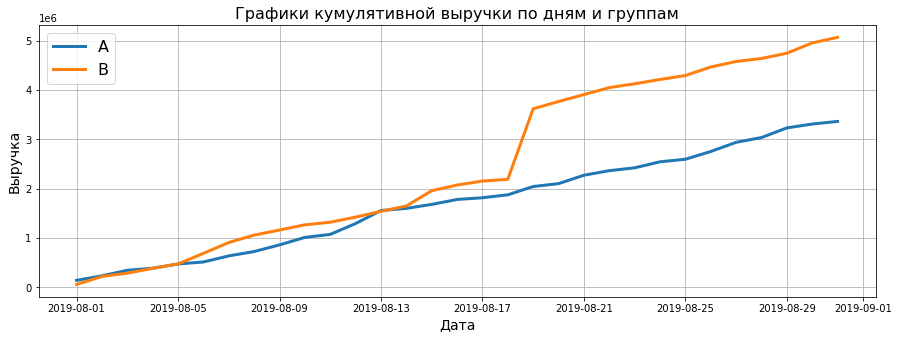

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A', linewidth=3)

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B', linewidth=3)



plt.title('Графики кумулятивной выручки по дням и группам', fontsize=16)
plt.xlabel('Дата', fontsize=14) 
plt.ylabel('Выручка', fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.show()

**Вывод:** Выручка растёт на протяжении всего теста для обоих групп. С 18.08 по 20.08 резкий скачок выручки в группе B, может быть вызван аномальными заказами (по сумме или кол-ву).

### Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

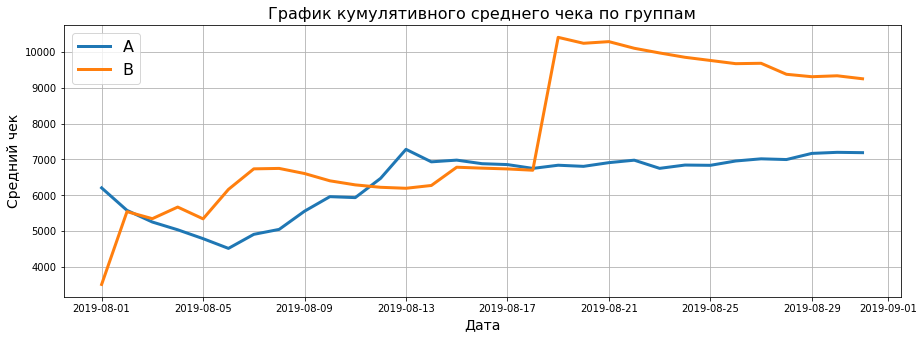

In [16]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A', linewidth=3)
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B', linewidth=3)
plt.title('График кумулятивного среднего чека по группам', fontsize=16)
plt.xlabel('Дата', fontsize=14) 
plt.ylabel('Средний чек', fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.show()

**Вывод:** Средний чек по группам постепенно растёт и начинает выравниваться к концу теста. С 18.08 по 20.08 резкий скачок среднего чека в группе B, скорее всего в эти даты произошли аномальное дорогие продажи.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

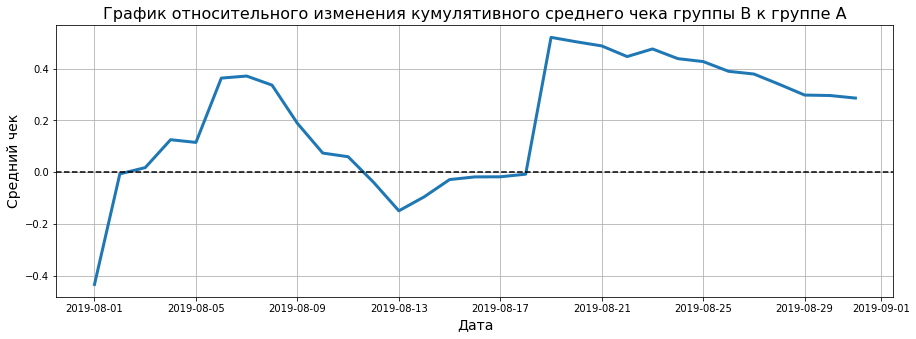

In [17]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, linewidth=3)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе А', fontsize=16)
plt.xlabel('Дата', fontsize=14) 
plt.ylabel('Средний чек', fontsize=14)
plt.grid()
plt.show()

**Вывод:** График не стабильный, скорее всего влияют аномальные продажи.

### Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

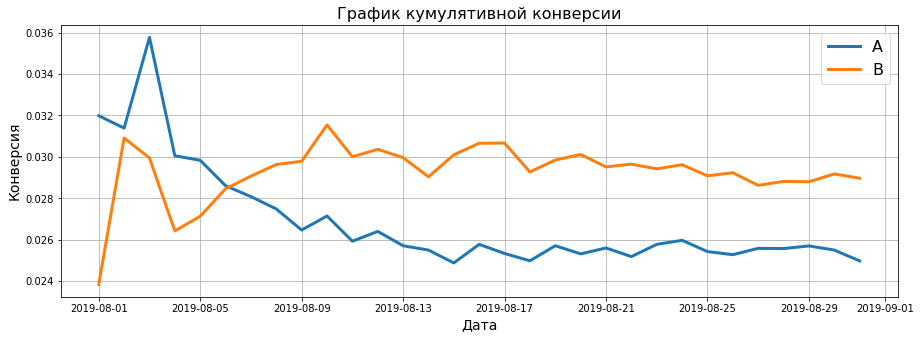

In [18]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A', linewidth=3)
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B', linewidth=3)
plt.title('График кумулятивной конверсии', fontsize=16)
plt.xlabel('Дата', fontsize=14) 
plt.ylabel('Конверсия', fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.show()

**Вывод:** График выравнялся, колебания не значительные, можно сказать что конверсия группы B выше чем у группы А.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

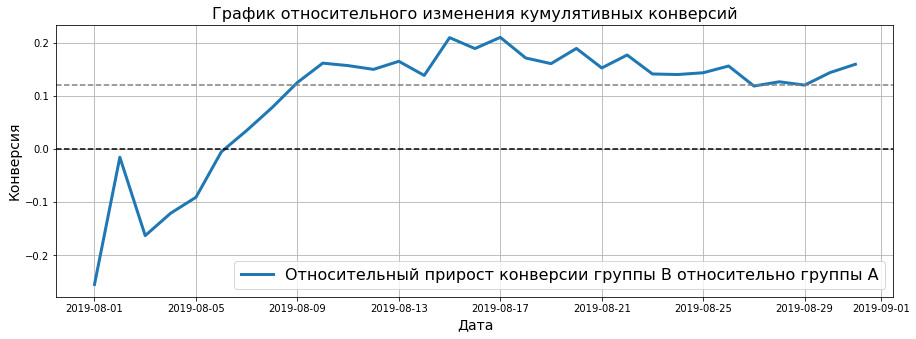

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A", linewidth=3)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивных конверсий', fontsize=16)
plt.xlabel('Дата', fontsize=14) 
plt.ylabel('Конверсия', fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.show()

**Вывод:** В целом график достаточно стабильный, можно сказать что конверсия группы B в среднем выше на ~ 12 %.

### Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

In [20]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

         userId  orders
908  3967698036  3     
55   249864742   3     
478  2108163459  3     
687  2988190573  3     
890  3908431265  3     
138  611059232   3     
632  2742574263  3     
157  678354126   2     
323  1404560065  2     
452  1985475298  2     


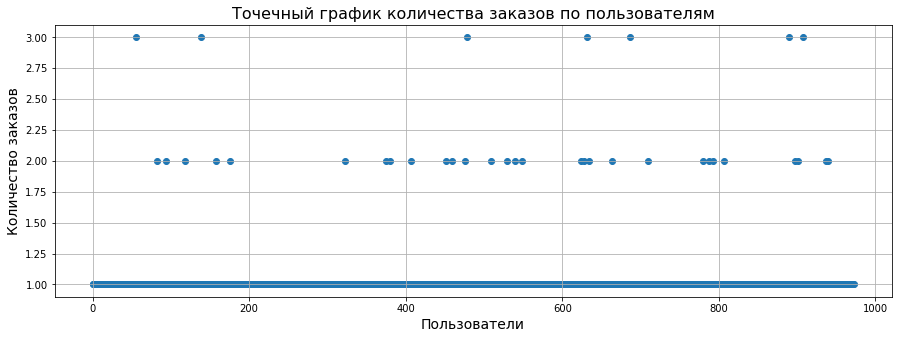

In [21]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(15,5))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям', fontsize=16)
plt.xlabel('Пользователи', fontsize=14) 
plt.ylabel('Количество заказов', fontsize=14)
plt.grid()
plt.show()

**Вывод:** Преобладающее большинство пользователей совершают от 1 до 2 заказов. Более 2х заказов - крайне редкое явление.

### Найдём 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [22]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

**Вывод:** Только 1% пользователей сделали более 2 заказов. Пользователей сделавших более 2 заказов будем считать аномальными.

### Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

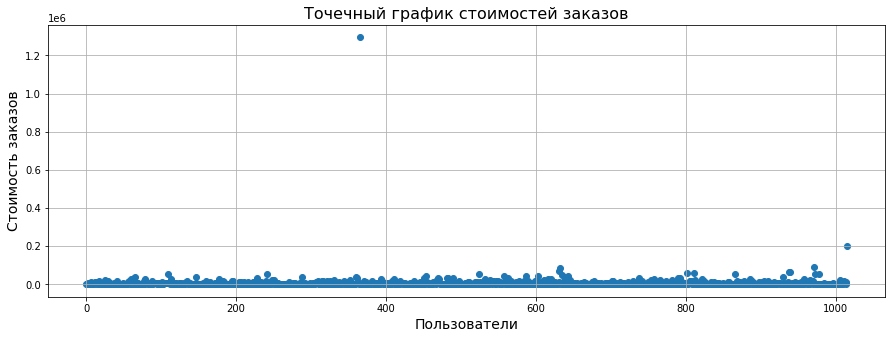

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов', fontsize=16)
plt.xlabel('Пользователи', fontsize=14) 
plt.ylabel('Стоимость заказов', fontsize=14)
plt.grid()
plt.show()

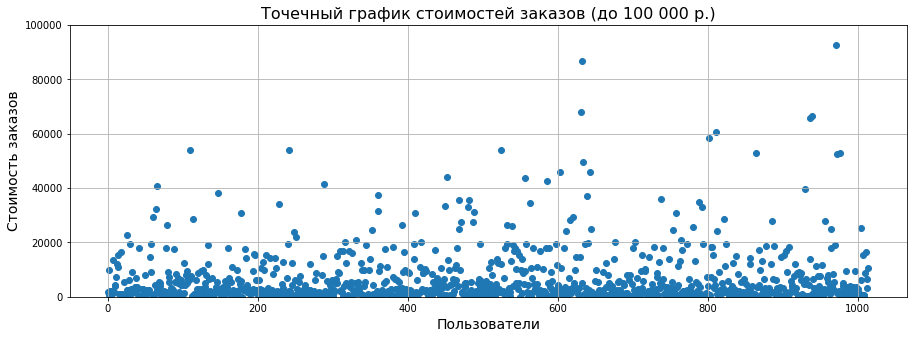

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов (до 100 000 р.)', fontsize=16)
plt.xlabel('Пользователи', fontsize=14) 
plt.ylabel('Стоимость заказов', fontsize=14)
plt.ylim(0, 100000)
plt.grid()
plt.show()

**Вывод:** Большая часть пользователей оформляет заказы на сумму до 40 000 р.

### Найдём 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [25]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

**Вывод:** Только 5% пользователей ооформляют заказы стоимостью выше 26 785 р. Будем считать все заказы с суммой выше 27 000р - аномальными.

### Найдём статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

Подготовим данные:

In [26]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Cформулируем гипотезы:

H0: Различий в среднем количестве заказов между группами нет   
H1: Различия в среднем количестве заказов между группами есть

In [27]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
0.160


**Вывод:** Нулевая гипотеза не подтвердилась, p-value ниже 0,05 => По сырым данным есть отличие в конверсии между группами (~13%).

### Найдём статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

Cформулируем гипотезы:

H0: Различий в среднем чеке между группами нет    
H1: Различия в среднем чеке между группами есть  

In [28]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
0.287


**Вывод:** Нулевая гипотеза подтвердилась, p-value выше 0,05 => По сырым данным, различий в среднем чеке между группами нет. Наблюдаемое различие в 28.7% не является статистически значимым.

### Найдём статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

Узнаем сколько всего аномальных пользователей:

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
revenue_lim = 27000
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: userId, dtype: int64
58


In [30]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Cформулируем гипотезы:

H0: Различий в среднем количестве заказов между группами нет   
H1: Различия в среднем количестве заказов между группами есть

In [31]:
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.012
0.182


**Вывод:** Нулевая гипотеза не подтвердилась, p-value ниже 0,05 => По очищенным данным есть отличие в конверсии между группами (~17%).

### Найдём статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

Cформулируем гипотезы:

H0: Различий в среднем чеке между группами нет    
H1: Различия в среднем чеке между группами есть  

In [32]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.646
-0.048


**Вывод:** Нулевая гипотеза подтвердилась, p-value выше 0,05 => По очищенным данным, различий в среднем чеке между группами нет. Без аномальных заказов относительная разница в среднем чеке пропала.

### Принятие решения по результатам теста.

**Решение:** Графики относительно стабильны, продолжать наблюдения смысла нет. Тест остановить и зафиксировать победу группы **B** по конверсии. В среднем чеке различий нет.

## Итоговый вывод

**Предобработка данных**

На этапе предобработки были проверены исходные данные на пропуски, дубликаты. Приведены к нижнему регистру названия столбцов в датафрейме hypothesis. Изменены названия столбцов в таблице orders. Преобразованы данные о времени.


**Приоритизация гипотез**  

При применении фреймворка ICE в приорите находились задачи:
- №8 Запустить акцию, дающую скидку на товар в день рождения
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

При применении фрейворка RICE в приоритет вышли такие задачи как:  

- №7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- №2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- №0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Задачи под номером 7 и 2 поднялись в приоритете в связи с тем что имеют высокий показатель охвата (reach), который не учитывается в фреймворке ICE.

**Анализ A/B-теста**

Кумулятивные метрики:
- Выручка растёт на протяжении всего теста для обоих групп. С 18.08 по 20.08 резкий скачок выручки в группе B.
- Средний чек по группам постепенно растёт и начинает выравниваться к концу теста. С 18.08 по 20.08 резкий скачок среднего чека в группе B.
- Конверсия группы B в среднем выше на ~ 12 %.  

Только 5% пользователей сделали более 2 заказов и только 5% пользователей ооформляют заказы с стоиомстью выше 28 000 р. Пользователей оформивших более 3х заказов и заказы с стоимостью выше 28 000 в даннном тесте будем считать аномальными.

Проверка гипотез:  
- По сырым и очищенным данным есть отличие в конверсии между группами (~13% и ~17% соответственно).
- По сырым и очищенным данным различий в среднем чеке между группами нет.

**Принятие решения по результатам теста:**   
Статистическо значимой разницы по среднему чеку не обнаруженно. При выросшем кол-ве заказов с сохранившимся средним чеком выручка будет так же расти. Тест считаем успешным и завершаем. Различия между грууппами есть только в конверсии, группа B показывает лучшую конверсию как по сырым так и по очищенным данным => принимаем группу B за победившую.